In [23]:
import aprofiles as apro
import numpy as np
import matplotlib.pyplot as plt

In [25]:
apro.__name__

'aprofiles'

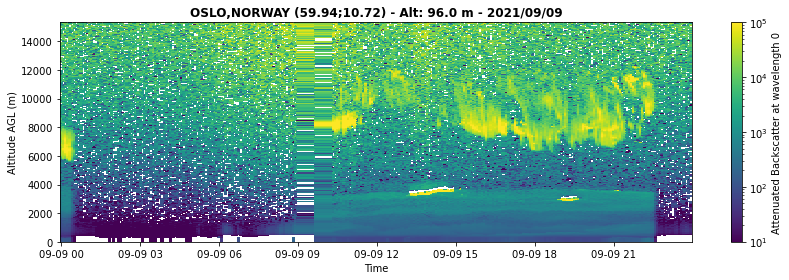

In [16]:
#path = "examples/data/L2_0-20000-006735_A20210908.nc"
path = "examples/data/L2_0-20000-001492_A20210909.nc"
apro_reader = apro.reader.ReadProfiles(path)
profiles = apro_reader.read()

profiles.range_correction(inplace=True)
profiles.extrapolation_lowest_layers(zmin=300, inplace=True)
profiles.gaussian_filter(sigma=0.0, inplace=True)
profiles.plot(vmin=1e1, vmax=1e5, log=True, cmap='viridis')

100%|██████████| 273/273 [00:01<00:00, 259.85it/s]


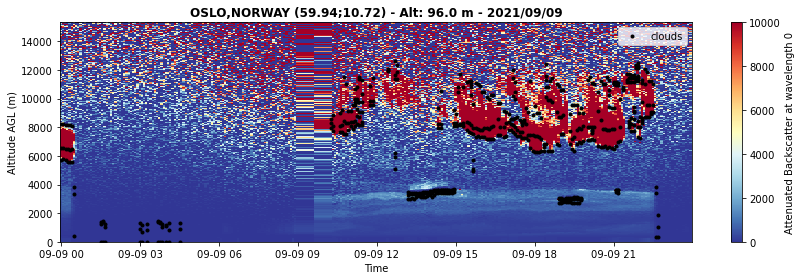

In [22]:
profiles.detect_clouds(time_avg=15, thr_noise=5, thr_clouds=4, verbose=True).plot(show_clouds=True)

In [3]:
def plot_clouds(profiles):
    time = profiles.data.time.data
    altitude = profiles.data.altitude.data

    for i in range(len(time)):
        #plot bases
        indexes = [i for i, x in enumerate(profiles.data.clouds_bases[i,:].data) if x]
        x = [time[i] for j, x in enumerate(indexes)]
        y = altitude[indexes]
        print(x)
        plt.plot(x, y, 'b.')

        #plot peaks
        indexes = [i for i, x in enumerate(profiles.data.clouds_peaks[i,:].data) if x]
        x = [time[i] for j, x in enumerate(indexes)]
        y = altitude[indexes]
        plt.plot(x, y, 'c.')
        
        #plot tops
        indexes = [i for i, x in enumerate(profiles.data.clouds_tops[i,:].data) if x]
        x = [time[i] for j, x in enumerate(indexes)]
        y = altitude[indexes]
        plt.plot(x, y, 'b.')
        
        attrs = profiles.data.clouds_bases.attrs
        plt.title('time avg: {}; thr_noise: {}; thr_clouds: {}'.format(attrs['time_avg'],attrs['thr_noise'],attrs['thr_clouds']), weight='bold')

[numpy.datetime64('2021-09-09T00:00:04.000000000'), numpy.datetime64('2021-09-09T00:00:04.000000000')]
[numpy.datetime64('2021-09-09T00:05:04.000000000')]
[numpy.datetime64('2021-09-09T00:10:04.000000000'), numpy.datetime64('2021-09-09T00:10:04.000000000')]
[numpy.datetime64('2021-09-09T00:15:04.000000000'), numpy.datetime64('2021-09-09T00:15:04.000000000')]
[numpy.datetime64('2021-09-09T00:20:04.000000256'), numpy.datetime64('2021-09-09T00:20:04.000000256')]
[numpy.datetime64('2021-09-09T00:25:03.999999744'), numpy.datetime64('2021-09-09T00:25:03.999999744')]
[numpy.datetime64('2021-09-09T00:30:04.000000256')]
[numpy.datetime64('2021-09-09T00:35:04.000000000')]
[numpy.datetime64('2021-09-09T00:40:04.000000000')]
[numpy.datetime64('2021-09-09T00:45:04.000000000')]
[numpy.datetime64('2021-09-09T00:50:04.000000000')]
[numpy.datetime64('2021-09-09T00:55:04.000000000')]
[numpy.datetime64('2021-09-09T01:00:04.000000000')]
[numpy.datetime64('2021-09-09T01:05:04.000000256')]
[numpy.datetime64

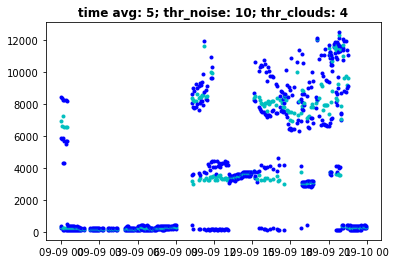

In [4]:
profiles.detect_clouds(time_avg=5, thr_noise=10, thr_clouds=4 , loading=False)
plot_clouds(profiles)

100%|██████████| 273/273 [00:00<00:00, 624.36it/s]


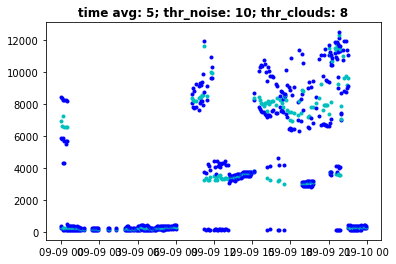

In [4]:
profiles.detect_clouds(time_avg=5, thr_noise=10, thr_clouds=8 , loading=True)
plot_clouds(profiles)

In [28]:
time = profiles.data.time.data
requested_datetime = np.datetime64('2021-09-09T16:00:00')
itime = np.argmin(abs(time-requested_datetime))

In [31]:
requested_datetime.tobytes()

b'\x80/:a\x00\x00\x00\x00'

'16:00:00'

In [15]:
time[0]

numpy.datetime64('2021-09-09T00:00:04.000000000')

In [3]:
a = [True, True, True, True]
a[0:2] = [False for i in range(len(a[0:2]))]

In [4]:
a

[False, False, True, True]